In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [4]:
np.random.seed(42)

In [5]:
def a20_index(y_train,y_pred):
  total = 0
  acc = 0
  for i in range(len(y_train.values)):

    temp = np.abs((y_pred[i]-y_train.values[i])/y_train.values[i])
    if temp<=0.2:
      total += 1
      acc += 1
    else:
      total += 1

  a20 = acc/total
  return a20

In [6]:
def mape(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Avoid division by zero by adding a small epsilon to y_true
    epsilon = 1e-10
    mape_value = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return mape_value


In [7]:
def vaf(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.var(y_true - y_pred)
    denominator = np.var(y_true)

    vaf_value = (1 - (numerator / denominator)) * 100
    return vaf_value


In [8]:
def rsr(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Compute standard deviation of y_true
    y_mean = np.mean(y_true)
    std_dev = np.sqrt(np.mean((y_true - y_mean) ** 2))

    rsr_value = rmse / std_dev
    return rsr_value


In [9]:
def evaluation_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape_value = mape(y_true, y_pred)
  vaf_value = vaf(y_true, y_pred)
  rsr_value = rsr(y_true, y_pred)
  a20 = a20_index(y_true, y_pred)
  return mae, r2, rmse, mape_value, vaf_value, rsr_value, a20

In [10]:
# Perform Randomized Search CV for each regressor
def randomized_search(model, param_grid, X, y, cv=5, n_iter=20):
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid,
        scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter,
        verbose=1, random_state=42, n_jobs=-1
    )
    random_search.fit(X, y)
    return random_search.best_params_

In [11]:
def randomized_search(model, param_grid, X, y, cv=5, n_iter=20):
    try:
        random_search = RandomizedSearchCV(
            estimator=model, param_distributions=param_grid,
            scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter,
            verbose=1, random_state=42, n_jobs=-1
        )
        random_search.fit(X, y)
        return random_search.best_params_
    except AttributeError as e:
        print(f"Error in RandomizedSearchCV: {e}")


In [12]:
def get_activation(layer):
    if hasattr(layer, 'activation'):
        return layer.activation.__name__
    return "linear"

def print_equations(model, input_names=None):
    if input_names is None:
        input_dim = model.input_shape[-1]   # FIXED
        input_names = [f"x{i+1}" for i in range(input_dim)]

    prev_outputs = input_names

    for layer_idx, layer in enumerate(model.layers):
        if not hasattr(layer, "get_weights"):  # skip if no weights
            continue

        weights, biases = layer.get_weights()
        activation = layer.activation.__name__ if hasattr(layer, 'activation') else "linear"
        curr_outputs = []

        print(f"\n--- Layer {layer_idx+1} ({activation}) ---")
        for j in range(weights.shape[1]):
            eq_terms = [f"({weights[i, j]:.4f}*{prev_outputs[i]})"
                        for i in range(weights.shape[0])]
            eq = " + ".join(eq_terms) + f" + ({biases[j]:.4f})"
            if activation != "linear":
                eq = f"{activation}({eq})"
            neuron_name = f"a{layer_idx+1}_{j+1}"
            print(f"{neuron_name} = {eq}")
            curr_outputs.append(neuron_name)

        prev_outputs = curr_outputs

# print_equations(ann)

# Stone Chips

## EDA

In [13]:
stone_df = pd.read_excel("/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/Stone NDT.xlsx")
stone_df.head()

,UPV (m/s),RN,Actual
0,4090,21.500000,22.334836
1,4090,21.333333,21.718515
2,4049,21.166667,21.965002
3,4132,21.500000,20.615770
4,4049,21.500000,22.581324


In [14]:
stone_df = stone_df.dropna()
stone_df.head()

,UPV (m/s),RN,Actual
0,4090,21.500000,22.334836
1,4090,21.333333,21.718515
2,4049,21.166667,21.965002
3,4132,21.500000,20.615770
4,4049,21.500000,22.581324


In [15]:
stone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UPV (m/s)  75 non-null     int64  
 1   RN         75 non-null     float64
 2   Actual     75 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [16]:
stone_df.describe()

,UPV (m/s),RN,Actual
count,75.000000,75.000000,75.000000
mean,4292.213333,25.251111,29.637026
std,207.659824,3.042168,6.144042
min,3082.000000,20.166667,19.253368
25%,4175.000000,22.750000,24.368579
50%,4310.000000,24.833333,29.607000
75%,4454.000000,27.583333,34.522194
max,4662.000000,32.000000,44.013293


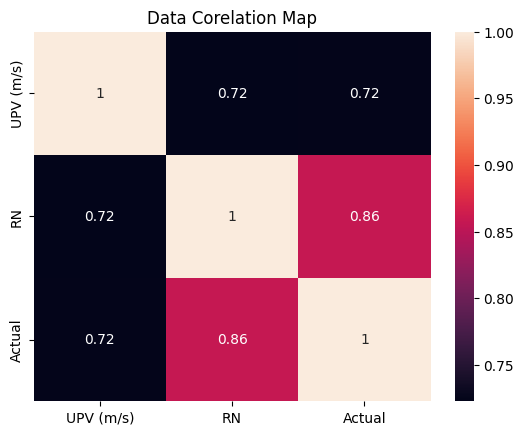

In [17]:
sns.heatmap(stone_df.corr(), annot=True)
plt.title("Data Corelation Map")
plt.show()

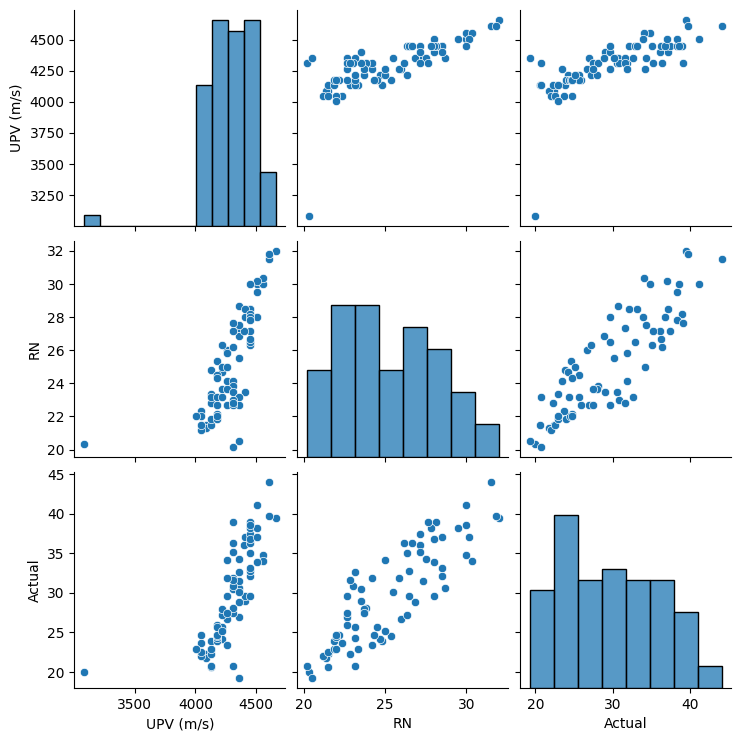

In [18]:
sns.pairplot(stone_df)
plt.show()

## Data Preprocessing

In [19]:
stone_df.columns

Index(['UPV (m/s)', 'RN', 'Actual'], dtype='object')

In [20]:
X = stone_df.drop("Actual", axis=1)
y = stone_df["Actual"]

In [21]:
X.head()

,UPV (m/s),RN
0,4090,21.500000
1,4090,21.333333
2,4049,21.166667
3,4132,21.500000
4,4049,21.500000


In [22]:
X.shape

(75, 2)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52, 2), (23, 2), (52,), (23,))

In [25]:
# Train = X_train
# Train["Actual"] = y_train
# Test = X_test
# Test["Actual"] = y_test
# Full = X
# Full["Actual"] = y

In [26]:
Train = X_train.copy()
Train["Actual"] = y_train.copy()

Test = X_test.copy()
Test["Actual"] = y_test.copy()

Full = X.copy()
Full["Actual"] = y.copy()

In [27]:
X.shape

(75, 2)

In [28]:
X.head()

,UPV (m/s),RN
0,4090,21.500000
1,4090,21.333333
2,4049,21.166667
3,4132,21.500000
4,4049,21.500000


In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

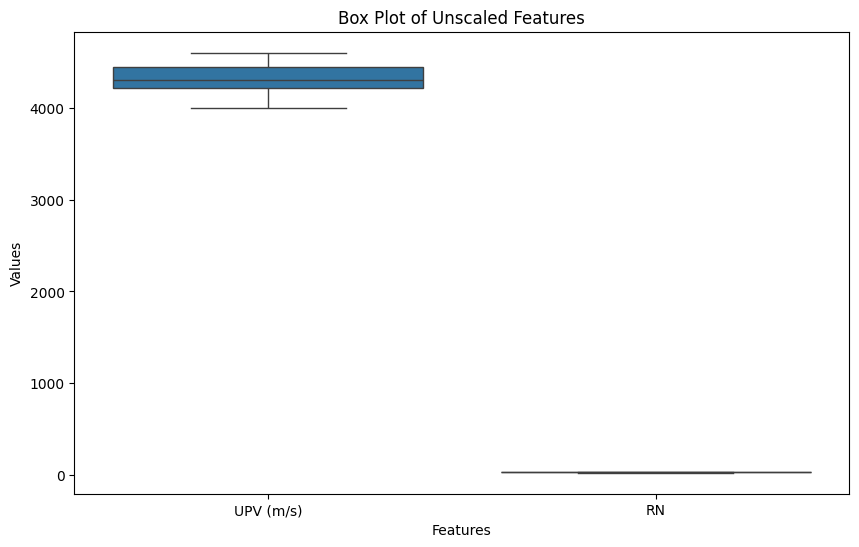

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train)
plt.title("Box Plot of Unscaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
#plt.set_xticklabels(X_train.columns, rotation=45)
plt.show()

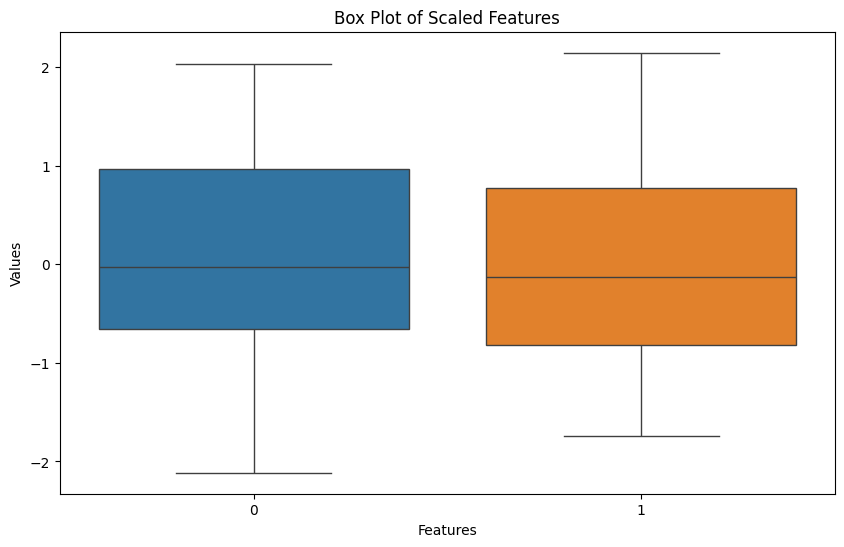

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train_scaled)
plt.title("Box Plot of Scaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

## ANN

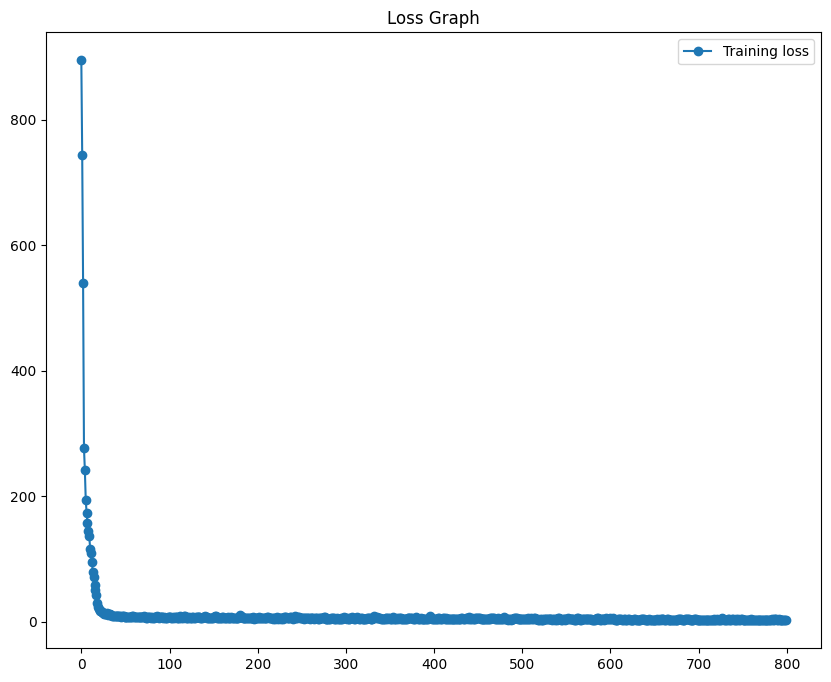

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
ANN Metrics:
MAE: 1.301419351670751
R2 Score: 0.9264826651330816
RMSE: 1.6547570772184161
MAPE: 4.260218618511229
VAF: 94.84773786083038
RSR: 0.2711408026596483
A20: 1.0


In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0002)
ann.compile(optimizer=optimizer, loss='mse')

r = ann.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = ann.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("ANN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [33]:
y_pred_train = ann.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("ANN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
ANN Train Metrics:
MAE: 1.207238643287028
R2 Score: 0.9339658464572599
RMSE: 1.5668421181015928
MAPE: 3.8980131104467914
VAF: 95.17574493247585
RSR: 0.2569711142185831
A20: 1.0


In [34]:
y_pred_test = ann.predict(X_test_scaled)

print(y_pred_test.shape)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("ANN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(23, 1)
ANN Test Metrics:
MAE: 1.5143498147425287
R2 Score: 0.9089348028417177
RMSE: 1.8380862204622093
MAPE: 5.079118453597302
VAF: 94.2304653455602
RSR: 0.30177010646895147
A20: 1.0


In [35]:
# print_equations(ann)

In [36]:
Train["ANN Predicted"] = y_pred_train
Test["ANN Predicted"] = y_pred_test
Full["ANN Predicted"] = y_pred

## CNN

In [37]:
X_scaled.shape

(75, 2)

In [38]:
n_sample,n_features = X_scaled.shape
print(n_sample,n_features)
X_scaled_reshaped = X_scaled.reshape((n_sample,n_features,1))

75 2


In [39]:
n_sample,n_features = X_train_scaled.shape
print(n_sample,n_features)
X_train_scaled_reshaped = X_train_scaled.reshape((n_sample,n_features,1))

52 2


In [40]:
n_sample,n_features = X_test_scaled.shape
print(n_sample,n_features)
X_test_scaled_reshaped = X_test_scaled.reshape((n_sample,n_features,1))

23 2


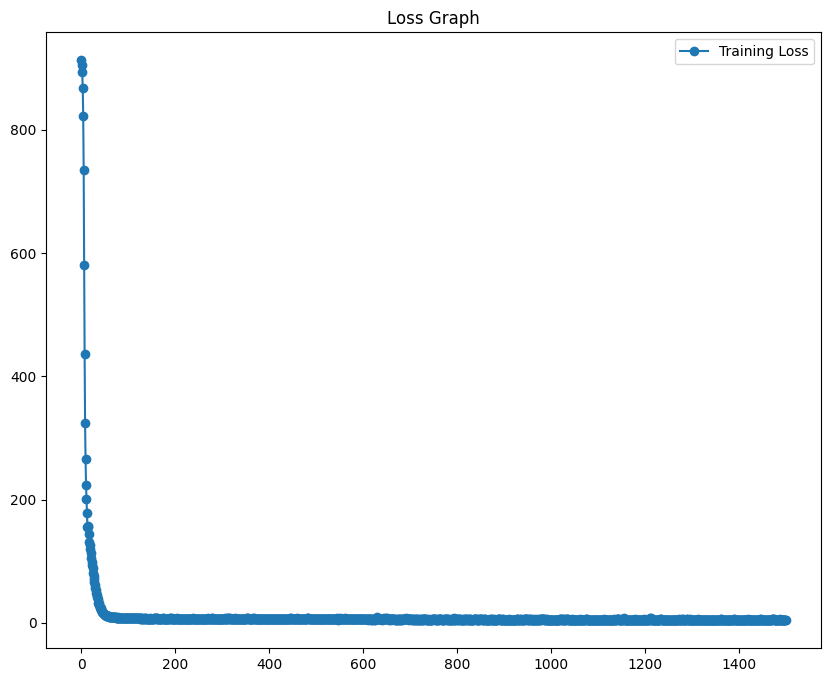

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
CNN Metrics:
MAE: 1.6502289973199682
R2 Score: 0.8853212703957523
RMSE: 2.0667160227077104
MAPE: 5.372688159589632
VAF: 88.56502183754411
RSR: 0.3386424805074634
A20: 1.0


In [41]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(n_features,1)),
    tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
cnn.compile(optimizer=optimizer, loss='mse')

r = cnn.fit(X_scaled, y, epochs=1500, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = cnn.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("CNN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [42]:
y_pred_train = cnn.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("CNN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
CNN Train Metrics:
MAE: 1.7688740863443388
R2 Score: 0.8698930259357662
RMSE: 2.1993341506355986
MAPE: 5.694640303695201
VAF: 86.9951122625696
RSR: 0.36070344337728993
A20: 1.0


In [43]:
y_pred_test = cnn.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("CNN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
CNN Test Metrics:
MAE: 1.3819880923386638
R2 Score: 0.9193482717639325
RMSE: 1.7298024274859851
MAPE: 4.644796485664417
VAF: 92.11128987048818
RSR: 0.2839924791892692
A20: 1.0


In [44]:
Train["CNN Predicted"] = y_pred_train
Test["CNN Predicted"] = y_pred_test
Full["CNN Predicted"] = y_pred

## LSTM

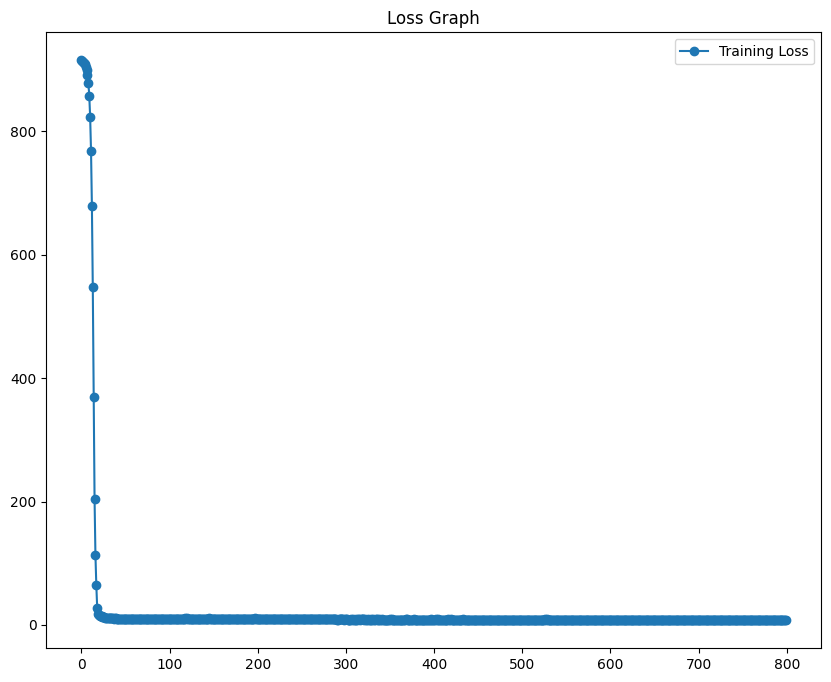

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
LSTM Metrics:
MAE: 2.2761247171746977
R2 Score: 0.7932734074534467
RMSE: 2.774837422750094
MAPE: 7.691248731729025
VAF: 79.65165368487908
RSR: 0.4546719614695339
A20: 0.9866666666666667


In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
lstm.compile(optimizer=optimizer, loss='mse')

r = lstm.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = lstm.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("LSTM Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [46]:
y_pred_train = lstm.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("LSTM Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM Train Metrics:
MAE: 2.576269120915538
R2 Score: 0.7484891831191867
RMSE: 3.0578717273524476
MAPE: 8.686891188615704
VAF: 75.00130534363916
RSR: 0.5015085411843085
A20: 0.9807692307692307


In [47]:
y_pred_test = lstm.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("LSTM Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM Test Metrics:
MAE: 1.5975372037303077
R2 Score: 0.8930646350009055
RMSE: 1.9918211577520755
MAPE: 5.440230359186957
VAF: 90.26131454475251
RSR: 0.32700973226969027
A20: 1.0


In [48]:
Train["LSTM Predicted"] = y_pred_train
Test["LSTM Predicted"] = y_pred_test
Full["LSTM Predicted"] = y_pred

## GRU

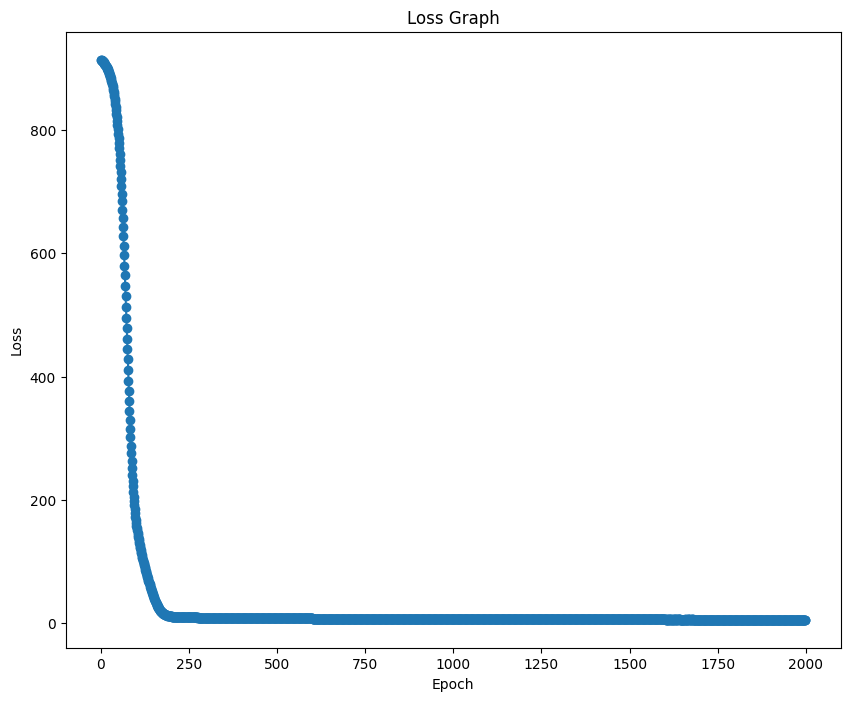

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
GRU Metrics:
MAE: 1.800733444516228
R2 Score: 0.8534664085091974
RMSE: 2.336188958028285
MAPE: 5.893781190435978
VAF: 85.3604288137616
RSR: 0.3827970630644945
A20: 0.9866666666666667


In [49]:
import tensorflow as tf
import matplotlib.pyplot as plt

gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Use a small learning rate for precise fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
gru.compile(optimizer=optimizer, loss='mse')

# Train for many epochs to allow memorization
r = gru.fit(X_scaled, y, epochs=2000, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions and evaluation
y_pred = gru.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("GRU Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [50]:
y_pred_train = gru.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("GRU Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
GRU Train Metrics:
MAE: 2.017768691402538
R2 Score: 0.8230588831147867
RMSE: 2.5648106702617177
MAPE: 6.627905194487947
VAF: 82.32902742696737
RSR: 0.4206436935046255
A20: 0.9807692307692307


In [51]:
y_pred_test = gru.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("GRU Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
GRU Test Metrics:
MAE: 1.3100447285387222
R2 Score: 0.9211727180037558
RMSE: 1.7101253282725484
MAPE: 4.234021777295811
VAF: 92.64713706175418
RSR: 0.28076196679081067
A20: 1.0


In [52]:
Train["GRU Predicted"] = y_pred_train
Test["GRU Predicted"] = y_pred_test
Full["GRU Predicted"] = y_pred

## Exporting Results

In [53]:
Full.head()

,UPV (m/s),RN,Actual,ANN Predicted,CNN Predicted,LSTM Predicted,GRU Predicted
0,4090,21.500000,22.334836,21.345356,21.820715,21.854713,22.560028
1,4090,21.333333,21.718515,20.922638,21.663719,21.693604,22.583355
2,4049,21.166667,21.965002,21.308237,21.970465,20.918390,22.701067
3,4132,21.500000,20.615770,20.801186,21.550493,22.530605,21.977104
4,4049,21.500000,22.581324,22.290722,22.290112,21.225357,22.690716


In [54]:
output_dir = "/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/"
Train.to_excel(f"{output_dir}V2_NDT_StoneChips_Train.xlsx", index=False)
Test.to_excel(f"{output_dir}V2_NDT_StoneChips_Test.xlsx", index=False)
Full.to_excel(f"{output_dir}V2_NDT_StoneChips_Full.xlsx", index=False)

# Brick Chips

## EDA

In [55]:
brick_df = pd.read_excel("/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/Bricks NDT.xlsx")
brick_df.head()

,UPV (m/s),RN,Actual
0,3781,20.666667,21.595237
1,3745,20.666667,20.855707
2,3676,20.666667,20.978985
3,3781,21.666667,22.819468
4,3854,21.500000,20.838056


In [56]:
brick_df = brick_df.dropna()
brick_df.head()

,UPV (m/s),RN,Actual
0,3781,20.666667,21.595237
1,3745,20.666667,20.855707
2,3676,20.666667,20.978985
3,3781,21.666667,22.819468
4,3854,21.500000,20.838056


In [57]:
brick_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UPV (m/s)  75 non-null     int64  
 1   RN         75 non-null     float64
 2   Actual     75 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.9 KB


In [58]:
brick_df.describe()

,UPV (m/s),RN,Actual
count,75.000000,75.000000,75.000000
mean,4083.813333,24.037778,29.132935
std,219.999244,2.278733,5.863900
min,3082.000000,20.166667,18.606020
25%,3968.000000,22.333333,24.615101
50%,4090.000000,23.666667,28.867538
75%,4264.000000,25.833333,34.443491
max,4357.000000,28.333333,39.467726


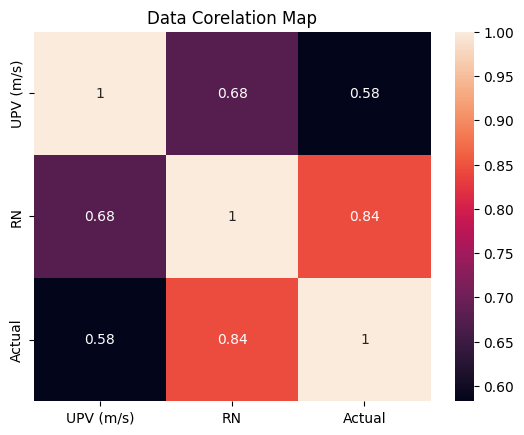

In [59]:
sns.heatmap(brick_df.corr(), annot=True)
plt.title("Data Corelation Map")
plt.show()

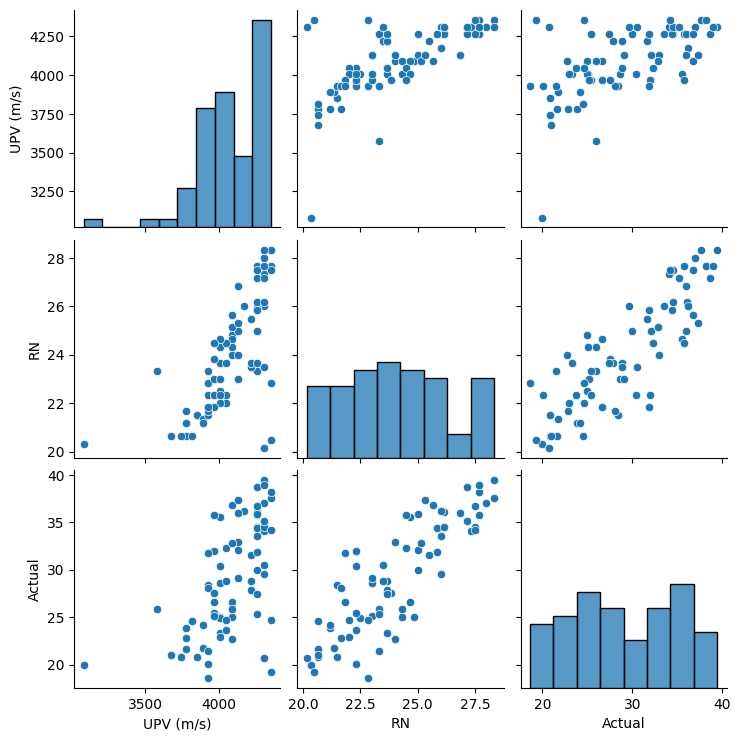

In [60]:
sns.pairplot(brick_df)
plt.show()

## Data Preprocessing

In [61]:
brick_df.columns

Index(['UPV (m/s)', 'RN', 'Actual'], dtype='object')

In [62]:
X = brick_df.drop("Actual", axis=1)
y = brick_df["Actual"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [64]:
# Train = X_train
# Train["Actual"] = y_train
# Test = X_test
# Test["Actual"] = y_test
# Full = X
# Full["Actual"] = y

In [65]:
Train = X_train.copy()
Train["Actual"] = y_train.copy()

Test = X_test.copy()
Test["Actual"] = y_test.copy()

Full = X.copy()
Full["Actual"] = y.copy()

In [66]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

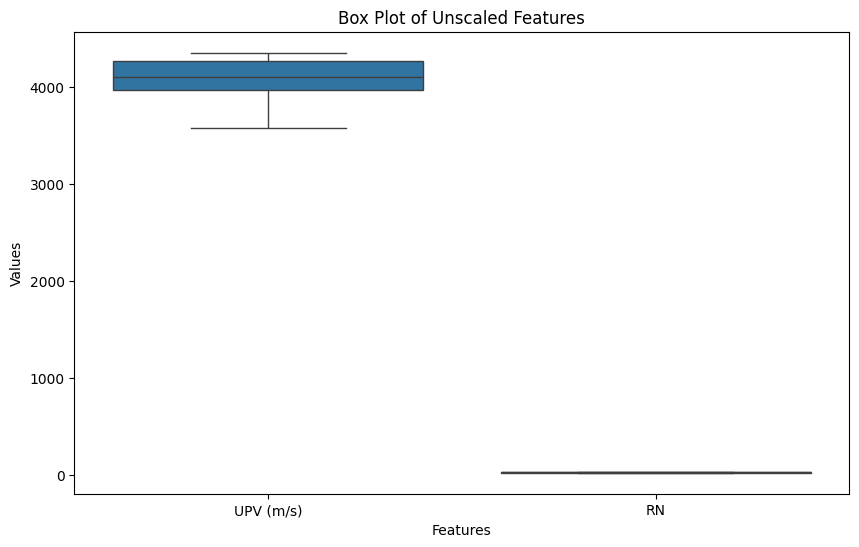

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train)
plt.title("Box Plot of Unscaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
#plt.set_xticklabels(X_train.columns, rotation=45)
plt.show()

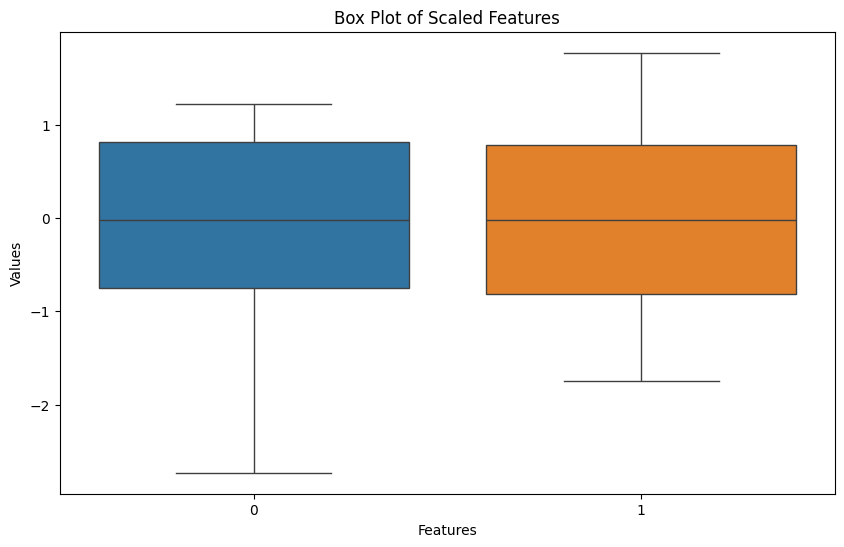

In [68]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train_scaled)
plt.title("Box Plot of Scaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

## ANN

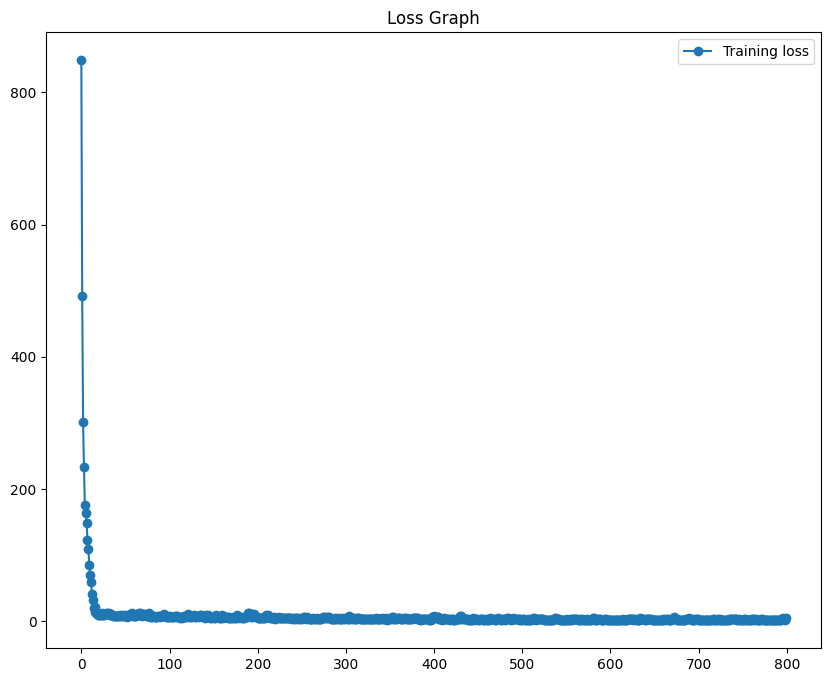

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
ANN Metrics:
MAE: 1.098349927557332
R2 Score: 0.9439204744796814
RMSE: 1.3793482691971541
MAPE: 3.8095598634175767
VAF: 94.54228311086626
RSR: 0.2368111600417484
A20: 1.0


In [69]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0002)
ann.compile(optimizer=optimizer, loss='mse')

r = ann.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = ann.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("ANN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [70]:
y_pred_train = ann.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("ANN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
ANN Train Metrics:
MAE: 1.2129893975352326
R2 Score: 0.9326346035894328
RMSE: 1.4942094936419572
MAPE: 4.155858039516044
VAF: 93.40560407361698
RSR: 0.2595484471357267
A20: 1.0


In [71]:
y_pred_test = ann.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("ANN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
ANN Test Metrics:
MAE: 0.8391650389116442
R2 Score: 0.9667270947653953
RMSE: 1.0753502096902714
MAPE: 3.026624812790797
VAF: 96.84609146448634
RSR: 0.18240862160162474
A20: 1.0


In [72]:
Train["ANN Predicted"] = y_pred_train
Test["ANN Predicted"] = y_pred_test
Full["ANN Predicted"] = y_pred

## CNN

In [73]:
n_sample,n_features = X_scaled.shape
print(n_sample,n_features)
X_scaled_reshaped = X_scaled.reshape((n_sample,n_features,1))

75 2


In [74]:
n_sample,n_features = X_train_scaled.shape
print(n_sample,n_features)
X_train_scaled_reshaped = X_train_scaled.reshape((n_sample,n_features,1))

52 2


In [75]:
n_sample,n_features = X_test_scaled.shape
print(n_sample,n_features)
X_test_scaled_reshaped = X_test_scaled.reshape((n_sample,n_features,1))

23 2


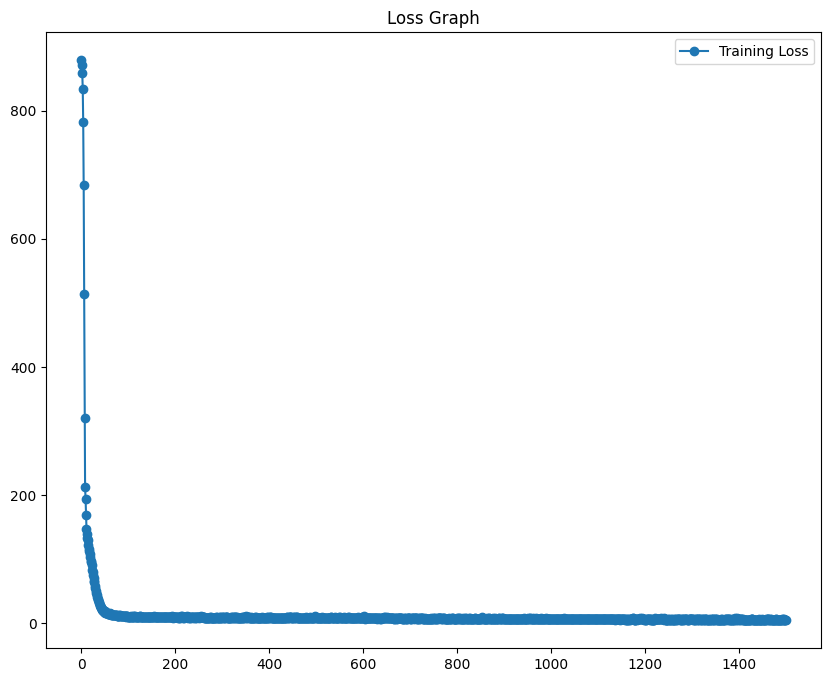

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
CNN Metrics:
MAE: 1.7741300792793417
R2 Score: 0.8533040939964393
RMSE: 2.2309034025779626
MAPE: 6.492467130988803
VAF: 85.5488336041692
RSR: 0.3830090155643347
A20: 0.9733333333333334


In [76]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(n_features,1)),
    tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
cnn.compile(optimizer=optimizer, loss='mse')

r = cnn.fit(X_scaled, y, epochs=1500, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = cnn.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("CNN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [77]:
y_pred_train = cnn.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("CNN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
CNN Train Metrics:
MAE: 1.7216980938916762
R2 Score: 0.8541481708195389
RMSE: 2.1986140382405877
MAPE: 6.050140367113502
VAF: 85.517685432168
RSR: 0.381905523893621
A20: 0.9807692307692307


In [78]:
y_pred_test = cnn.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("CNN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CNN Test Metrics:
MAE: 1.892672125142642
R2 Score: 0.8474926152307891
RMSE: 2.3022368416968364
MAPE: 7.492510787374945
VAF: 85.38547089711797
RSR: 0.39052193890895665
A20: 0.9565217391304348


In [79]:
Train["CNN Predicted"] = y_pred_train
Test["CNN Predicted"] = y_pred_test
Full["CNN Predicted"] = y_pred

## LSTM

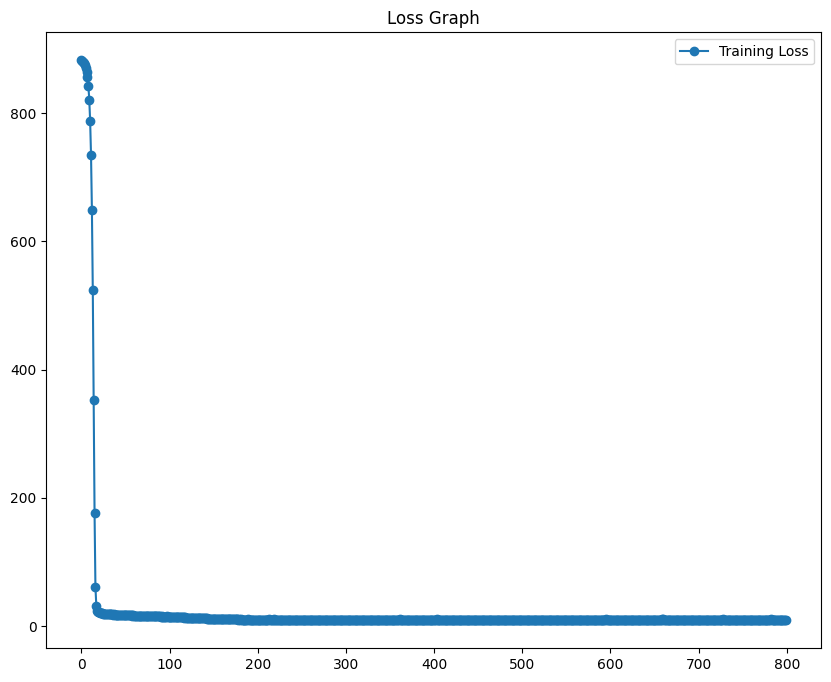

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
LSTM Metrics:
MAE: 2.37444917140558
R2 Score: 0.7225325191468716
RMSE: 3.0681586643477
MAPE: 8.53891018674917
VAF: 72.25989635554187
RSR: 0.5267518209300547
A20: 0.8933333333333333


In [80]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
lstm.compile(optimizer=optimizer, loss='mse')

r = lstm.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = lstm.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("LSTM Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [81]:
y_pred_train = lstm.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("LSTM Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM Train Metrics:
MAE: 2.503615866114088
R2 Score: 0.6892505948403458
RMSE: 3.2092105375537585
MAPE: 8.910202171154374
VAF: 68.92591894066187
RSR: 0.5574490157491125
A20: 0.8846153846153846


In [82]:
y_pred_test = lstm.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("LSTM Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
LSTM Test Metrics:
MAE: 2.0824203712839946
R2 Score: 0.7867389805095046
RMSE: 2.722452449540713
MAPE: 7.699468085193492
VAF: 78.71306090974853
RSR: 0.4618019266855601
A20: 0.9130434782608695


In [83]:
Train["LSTM Predicted"] = y_pred_train
Test["LSTM Predicted"] = y_pred_test
Full["LSTM Predicted"] = y_pred

## GRU

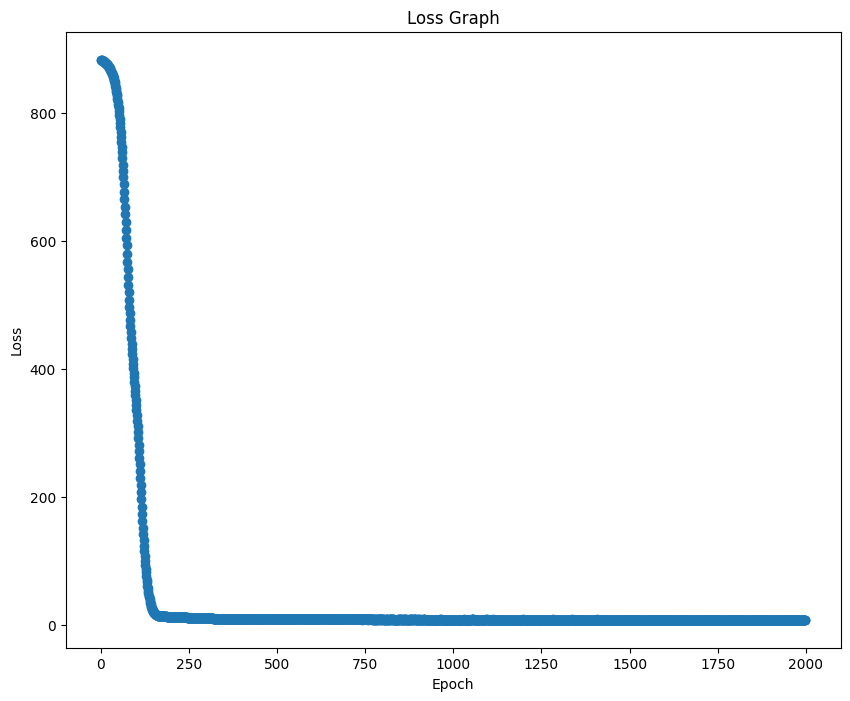

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
GRU Metrics:
MAE: 2.291317671189634
R2 Score: 0.7359628862535896
RMSE: 2.992983050398846
MAPE: 8.16026796400575
VAF: 74.02926772262457
RSR: 0.5138454181428597
A20: 0.9066666666666666


In [90]:
import tensorflow as tf
import matplotlib.pyplot as plt

gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Use a small learning rate for precise fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
gru.compile(optimizer=optimizer, loss='mse')

# Train for many epochs to allow memorization
r = gru.fit(X_scaled, y, epochs=2000, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions and evaluation
y_pred = gru.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("GRU Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [94]:
y_pred_train = gru.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("GRU Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
GRU Train Metrics:
MAE: 2.3907666852726006
R2 Score: 0.7095123977750513
RMSE: 3.1028219670324524
MAPE: 8.3999626561585
VAF: 71.41118336130152
RSR: 0.5389690178711098
A20: 0.9038461538461539


In [95]:
y_pred_test = gru.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("GRU Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
GRU Test Metrics:
MAE: 2.0664766707431848
R2 Score: 0.7858060336059118
RMSE: 2.728400868613099
MAPE: 7.618350147207447
VAF: 78.96831853984388
RSR: 0.4628109402273115
A20: 0.9130434782608695


In [96]:
Train["GRU Predicted"] = y_pred_train
Test["GRU Predicted"] = y_pred_test
Full["GRU Predicted"] = y_pred

## Exporting Results

In [97]:
Full.head()

,UPV (m/s),RN,Actual,ANN Predicted,CNN Predicted,LSTM Predicted,GRU Predicted
0,3781,20.666667,21.595237,22.402191,22.480801,21.978245,22.429089
1,3745,20.666667,20.855707,22.171930,22.406776,21.813662,22.233599
2,3676,20.666667,20.978985,22.399187,22.647396,21.504086,21.875126
3,3781,21.666667,22.819468,22.383926,24.556942,23.164202,23.293730
4,3854,21.500000,20.838056,21.855959,23.850750,23.393274,23.598703


In [98]:
output_dir = "/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/"
Train.to_excel(f"{output_dir}V2_NDT_BrickChips_Train.xlsx", index=False)
Test.to_excel(f"{output_dir}V2_NDT_BrickChips_Test.xlsx", index=False)
Full.to_excel(f"{output_dir}V2_NDT_BrickChips_Full.xlsx", index=False)